In [535]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [536]:
data_pd = pd.read_csv('output.csv')
data_pd.describe()

# Transofrm data into a dict with values as np.arrays
data_pd.describe()


,Event,ID,Stream,Time,Pclass
count,11245.000000,11245.000000,11245.000000,1.124500e+04,11245.000000
mean,99757.396443,1.236105,-21.560783,6.427088e-07,2.365763
std,145.106933,0.424706,18.882554,3.540576e-07,1.657229
min,99501.000000,1.000000,-48.000000,1.394630e-08,0.000000
25%,99633.000000,1.000000,-39.000000,3.578030e-07,1.000000
50%,99758.000000,1.000000,-22.000000,6.646390e-07,2.000000
75%,99884.000000,1.000000,-4.000000,9.396350e-07,4.000000
max,99997.000000,2.000000,11.000000,1.242880e-06,5.000000


In [537]:
data = dict()
for col in data_pd.columns:
    data[col] = data_pd[col].values

## Looking at one single event

In [538]:
N_EV = np.unique(data['Event'][data['Pclass'] == 5])[4]
N_EV

99625

In [539]:
#select an event using data_dict['Event']
mask_ev1 = data['Event'] == N_EV

ev1 = {}
for k in data.keys():
    ev1[k] = data[k][mask_ev1]


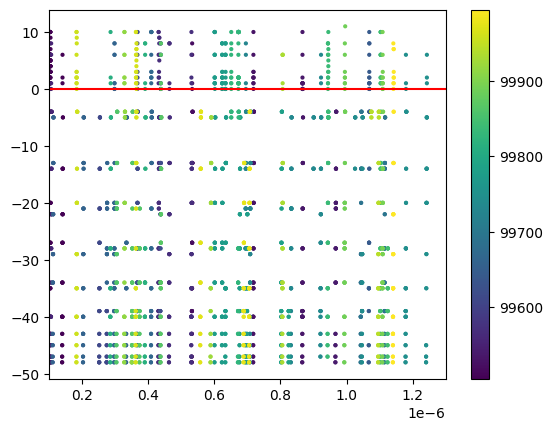

In [540]:
class_mask = data['Pclass'] == 1
plt.scatter(data['Time'][class_mask], data['Stream'][class_mask],c=data['Event'][class_mask] , s =4)
plt.colorbar()
plt.xlim(1e-7, 13e-7)
plt.axhline(0, c = 'r')

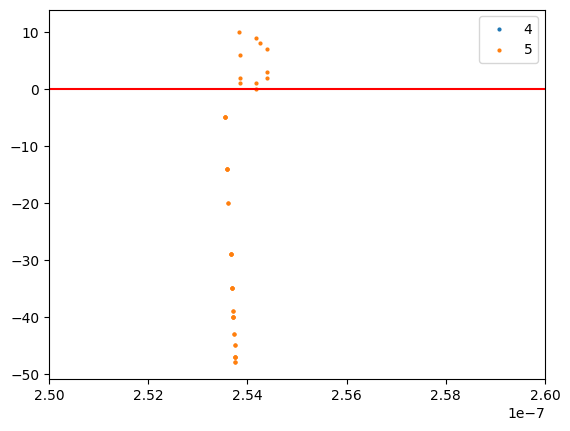

In [541]:
class_mask_i = data['Pclass'] == 5
class_mask_j = data['Pclass'] == 4

plt.scatter(data['Time'][class_mask_i], data['Stream'][class_mask_i], s =4, label = "4")
plt.scatter(data['Time'][class_mask_j], data['Stream'][class_mask_j], s =4, label = "5")
plt.legend()
plt.xlim(2.5e-7, 2.6e-7)
plt.axhline(0, c = 'r')

## Divide time track and time of neurons

In [542]:
t_track = ev1['Time'][ev1['ID'] == 1]
t_track

array([6.35689e-07, 6.35689e-07, 6.35696e-07, 6.35696e-07, 6.35706e-07,
       6.35706e-07, 6.35715e-07, 6.35715e-07, 6.35730e-07, 6.35730e-07,
       6.35730e-07, 6.35730e-07, 6.35731e-07, 6.35731e-07, 6.35756e-07,
       6.35756e-07, 6.35792e-07, 6.35792e-07, 6.35792e-07, 6.35792e-07,
       6.35822e-07, 6.35822e-07, 6.35822e-07, 6.35822e-07, 6.35864e-07,
       6.35864e-07, 6.35864e-07, 6.35864e-07, 6.35909e-07, 6.35909e-07])

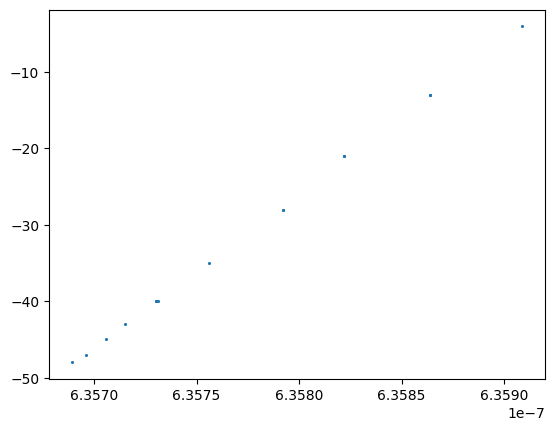

In [543]:
#plot the track of a single particle
plt.scatter(t_track, ev1['Stream'][ev1['ID'] == 1], s=1)

In [544]:
t_neur = ev1['Time'][ev1['ID'] == 2]
t_neur

array([6.36020e-07, 6.36093e-07, 6.36093e-07, 6.36093e-07, 6.36152e-07,
       6.36596e-07, 6.36596e-07, 6.36711e-07, 6.36711e-07])

In [545]:
hit_neur = ev1['Stream'][ev1['ID'] == 2]
hit_neur

array([ 8,  0,  1,  6, 10,  1,  2,  2,  3])

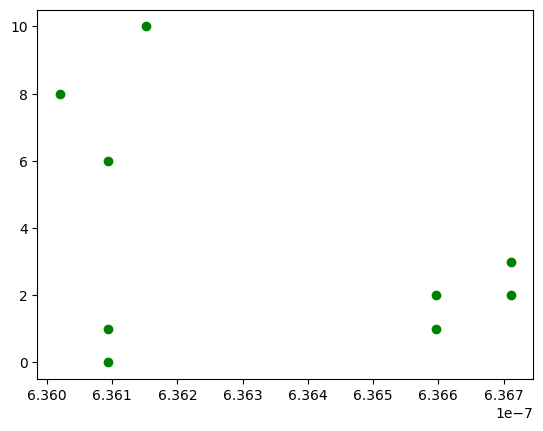

In [546]:
plt.scatter(t_neur, ev1['Stream'][ev1['ID'] == 2], c='g')


In [547]:
min_t_track = np.min(t_track)
max_t_track = np.max(t_track)

mask_sel_neur = np.logical_and(t_neur>min_t_track, t_neur<max_t_track)
mask_sel_neur

array([False, False, False, False, False, False, False, False, False])

(6.35689e-07, 6.35909e-07)

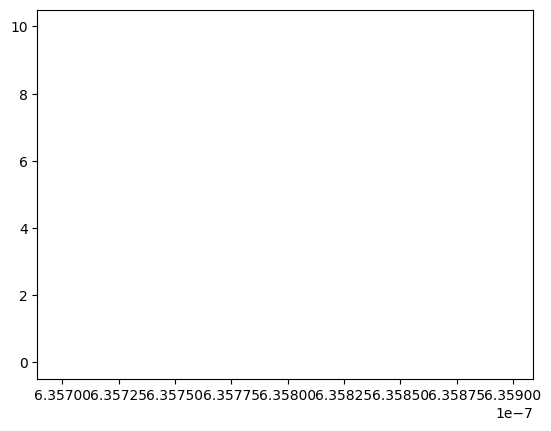

In [548]:
plt.scatter(t_neur, ev1['Stream'][ev1['ID'] == 2], c='g')
plt.xlim(min_t_track, max_t_track)


In [549]:
#Using min_t_track and max_t_track,let's bin in 10 bins the time interval and put the hits of neuron inside the bins
n_bins = 12
bins = np.arange(1, n_bins+1)
print(bins.shape)
print(bins)
hist_y, bin_edges_y = np.histogram(hit_neur[mask_sel_neur], bins=bins)
hist_y
# bins = np.linspace(min_t_track, max_t_track, n_bins)
# hist, bin_edges = np.histogram(t_neur, bins=bins)
# hist


(12,)
[ 1  2  3  4  5  6  7  8  9 10 11 12]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## For All Events

In [550]:
def get_hist_neuron(N_EV, data, N_NEUR):

    """
    This function returns the histogram of the neuron hits inside the track of the particle
    """
    #select an event using data_dict['Event']
    mask_ev1 = data['Event'] == N_EV
    
    ev1 = {}

    for k in data.keys():
        ev1[k] = data[k][mask_ev1]

    t_track = ev1['Time'][ev1['ID'] == 1]

    t_neur = ev1['Time'][ev1['ID'] == 2]
    hit_neur = ev1['Stream'][ev1['ID'] == 2]

    min_t_track = np.min(t_track) - 0.4e-7
    max_t_track = np.max(t_track) + 0.4e-7
    mask_sel_neur = np.logical_and(t_neur>min_t_track, t_neur<max_t_track)

    bins = np.arange(0, N_NEUR+1)

    #now check if inside the t_neuron there are values inside the bins
    hist, bin_edges = np.histogram(hit_neur[mask_sel_neur], bins=bins)

    return hist


In [551]:
N_EV_class0 = np.unique(data['Event'][data['Pclass'] == 0])
N_EV_class1 = np.unique(data['Event'][data['Pclass'] == 1])
N_EV_class2 = np.unique(data['Event'][data['Pclass'] == 2])
N_EV_class3 = np.unique(data['Event'][data['Pclass'] == 3])
N_EV_class4 = np.unique(data['Event'][data['Pclass'] == 4])
N_EV_class5 = np.unique(data['Event'][data['Pclass'] == 5])

In [552]:
for EV in N_EV_class5:
    print(get_hist_neuron(EV, data,12))


[1 2 1 0 0 0 1 0 1 0 1 0]
[2 3 3 2 0 0 1 2 1 0 1 2]
[2 5 3 0 0 0 4 1 1 0 2 1]
[0 1 1 0 0 0 1 0 0 0 1 0]
[1 2 2 1 0 0 1 0 1 0 1 0]
[1 2 1 0 0 0 1 1 1 0 0 0]
[1 2 2 1 0 0 1 1 1 0 1 0]
[1 2 1 0 0 0 1 1 1 0 1 0]
[1 2 1 0 0 0 1 0 1 0 1 0]
[1 2 1 0 0 0 1 0 1 0 1 1]
[1 2 5 4 0 0 1 0 1 1 1 4]
[0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 0 0 0 1 0 0 0 1 0]
[1 2 2 1 0 0 1 1 1 0 1 0]
[2 2 0 0 0 0 2 0 2 0 0 0]
[0 1 1 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0]
[1 2 1 0 0 0 1 0 0 0 1 0]
[1 2 2 1 0 0 1 0 1 0 1 1]
[2 3 2 2 2 2 2 1 2 1 1 0]
[0 1 2 1 0 0 1 0 0 0 1 0]
[2 3 2 1 0 1 2 0 2 1 1 1]
[1 2 1 0 0 0 1 1 1 0 1 0]
[0 1 1 0 0 0 1 0 0 0 1 0]
[0 1 1 0 0 0 1 0 1 0 1 0]
[0 1 2 1 0 0 1 0 1 0 1 0]
[1 2 2 1 0 1 2 1 1 0 1 1]
[1 1 0 0 0 0 1 0 0 0 0 0]


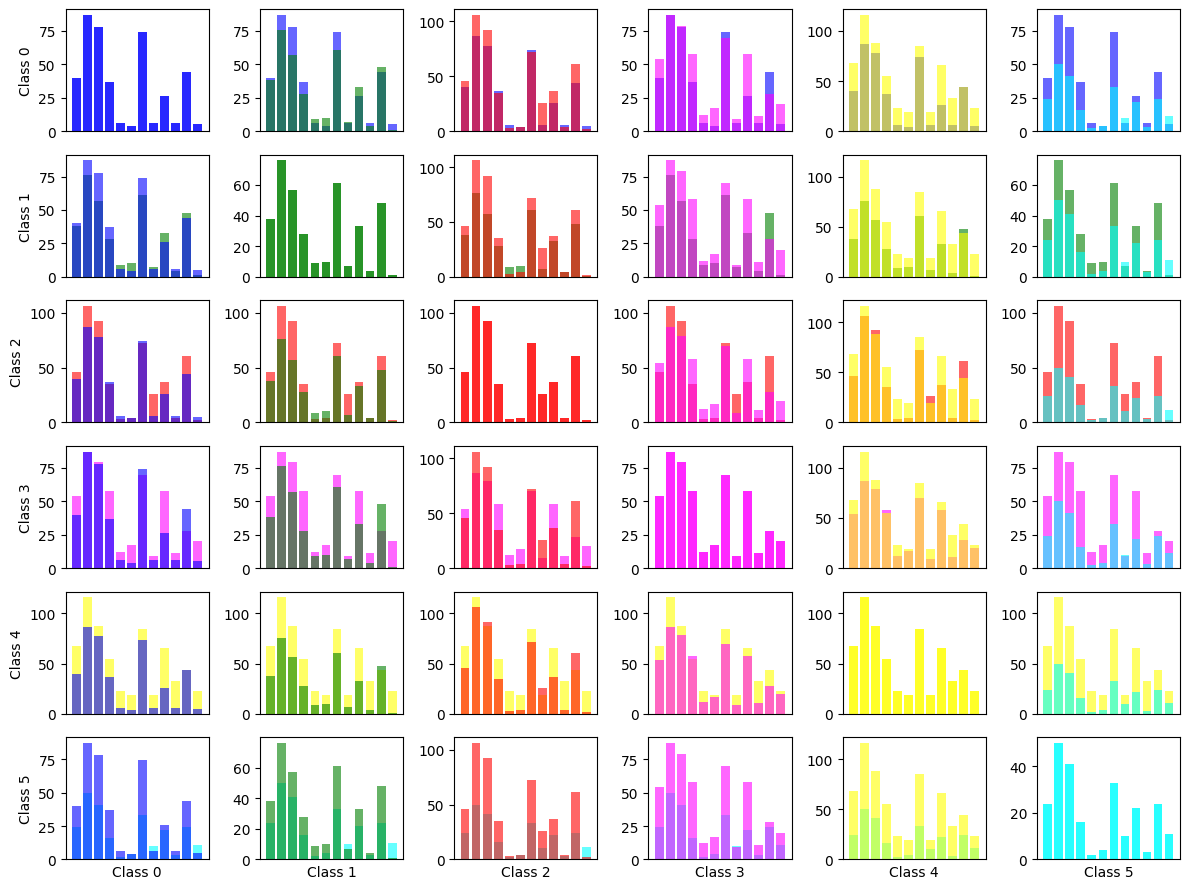

In [553]:
hist0 = np.zeros(12)
hist1 = np.zeros(12)
hist2 = np.zeros(12)
hist3 = np.zeros(12)
hist4 = np.zeros(12)
hist5 = np.zeros(12)

H0 = []
H1 = []
H2 = []
H3 = []
H4 = []
H5 = []

for EV in N_EV_class0:
    hist0 = hist0 + get_hist_neuron(EV, data,12)
    H0.append(get_hist_neuron(EV, data,12))


for EV in N_EV_class1:
    hist1 = hist1 + get_hist_neuron(EV, data,12)
    H1.append(get_hist_neuron(EV, data,12))



for EV in N_EV_class2:
    hist2 = hist2 + get_hist_neuron(EV, data,12)
    H2.append(get_hist_neuron(EV, data,12))



for EV in N_EV_class3:
    hist3 = hist3 + get_hist_neuron(EV, data,12)
    H3.append(get_hist_neuron(EV, data,12))




for EV in N_EV_class4:
    hist4 = hist4 + get_hist_neuron(EV, data,12)
    H4.append(get_hist_neuron(EV, data,12))



for EV in N_EV_class5:
    hist5 = hist5 + get_hist_neuron(EV, data,12)
    H5.append(get_hist_neuron(EV, data,12))


HISTS = [hist0, hist1, hist2, hist3, hist4, hist5]
HISTS = np.array(HISTS)

COLORS = ['b', 'g', 'r', 'magenta', 'yellow', 'cyan']

#Now create a matrix plot comparing hist_i and hist_j
plt.subplots(6,6, figsize=(12,9))
for i in range(6):
    for j in range(6):
        plt.subplot(6,6,6*i+j+1)
        plt.bar(np.arange(len(HISTS[i])),HISTS[i], color = COLORS[i], alpha = 0.6)
        plt.bar(np.arange(len(HISTS[j])),HISTS[j], color = COLORS[j], alpha = 0.6)
        plt.xticks([])

        #I want the labels only on the right and on the top
        if j == 0:
            plt.ylabel('Class {}'.format(i))
        if i == 5:
            plt.xlabel('Class {}'.format(j))
        #plot the axes on every histo

            

plt.tight_layout()

# PCA analysis

In [554]:
H = H0 + H1 + H2 + H3 + H4 + H5

label = []
for i in range(len(H0)):
    label.append(0)
for i in range(len(H1)):
    label.append(1)
for i in range(len(H2)):
    label.append(2)
for i in range(len(H3)):
    label.append(3)
for i in range(len(H4)):
    label.append(4)
for i in range(len(H5)):
    label.append(5)

label = np.array(label)
H

[array([2, 4, 3, 1, 0, 0, 5, 0, 2, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([1, 3, 3, 2, 1, 0, 1, 1, 1, 0, 3, 0]),
 array([2, 3, 2, 1, 0, 0, 4, 0, 1, 0, 0, 0]),
 array([1, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0]),
 array([1, 2, 3, 2, 0, 0, 1, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([4, 5, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 2, 3, 2, 0, 0, 1, 1, 1, 0, 1, 0]),
 array([1, 3, 8, 6, 0, 0, 2, 0, 1, 1, 3, 0]),
 array([1, 7, 6, 0, 0, 0, 1, 0, 1, 2, 1, 0]),
 array([1, 2, 5, 4, 0, 0, 1, 0, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 4, 11,  8,  2,  1,  1, 12,  0,  0,  0, 12,  0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 3, 3, 1, 0, 0, 1, 0, 4, 0, 0, 0]),
 array([1, 5, 4, 0, 0, 0, 1, 0, 2, 0, 1, 1]),
 array([1, 2, 3, 2, 0,

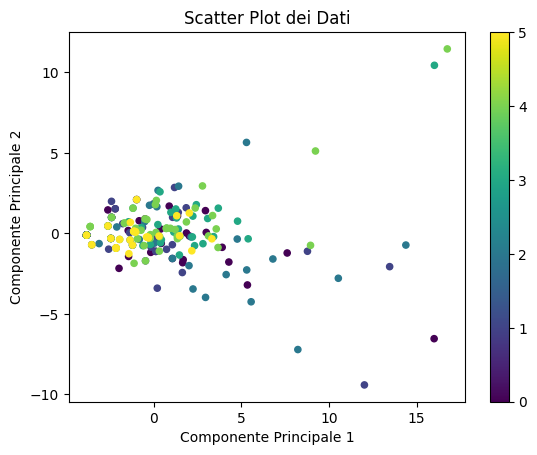

In [555]:
from sklearn.decomposition import PCA

# Esempio di dati: vettori binari (False/True)

# Riduzione della dimensionalità utilizzando PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(H)

# Plot dei dati
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=label, s=20)
plt.colorbar()
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('Scatter Plot dei Dati')

plt.show()
